# Overview

The following mapping tool applies the Random Forest Classifier trained on our Algeria dataset to U.S. county level data.

In [12]:
#import packages as needed 

import plotly.figure_factory as ff

import numpy as np
import pandas as pd
!pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download and clean US data

In [2]:
#download U.S. map data and county shapefile. 

us_data = {'county_prcp_202303':'https://raw.githubusercontent.com/ebwieman/wildfire-risk-tool/main/prcp-202303-cty-prelim%20(1).csv', 'county_tmax_202303':'https://raw.githubusercontent.com/ebwieman/wildfire-risk-tool/main/tmax-202303-cty-prelim%20(1).csv', 'county_prcp_202007':'https://raw.githubusercontent.com/ebwieman/wildfire-risk-tool/main/prcp-202007-cty-scaled.csv', 'county_tmax_202007':'https://raw.githubusercontent.com/ebwieman/wildfire-risk-tool/main/tmax-202007-cty-scaled%20(2).csv'}

COUNTIES_URL = 'https://raw.githubusercontent.com/ebwieman/wildfire-risk-tool/main/cb_2018_us_county_5m.zip'

#download precipitation and temperature data, assign labels, rename columns. 
FEATURES = ['Temperature', 'Rain ']
def clean_us_data(url):
  df = pd.read_csv(url, header=None)
  df = df.drop([0,3, 4, 5], axis=1)
  df = df.rename(columns={1:'cty code', 2: 'cty', 6:1, 7:2, 8:3, 9:4, 10:5, 11:6, 12:7, 13:8, 14:9, 15:10, 16:11, 17:12, 18:13, 19:14, 20:15, 21:16, 22:17, 23:18, 24:19, 25:20, 26:21, 27:22, 28:23, 29:24, 30:25, 31:26, 32:27, 33:28, 34:29, 35:30, 36:31})
  return df

#prepare the data for maching learning
def prep_us_data(temp_data, prcp_data, day): #added 

  tmax_df = clean_us_data(temp_data)
  prcp_df = clean_us_data(prcp_data)

  tmax_df = tmax_df.add_prefix('tmax_')
  tmax_df = tmax_df.rename(columns={'tmax_cty code': 'cty code', 'tmax_cty': 'cty'})

  prcp_df = prcp_df.add_prefix('prcp_')
  prcp_df = prcp_df.rename(columns={'prcp_cty code': 'cty code', 'prcp_cty': 'cty'})

  counties_df = tmax_df.merge(prcp_df, on=['cty','cty code'])

  tmax_col = 'tmax_' + day
  prcp_col = 'prcp_' + day

  data = counties_df[['cty code', 'cty', tmax_col, prcp_col]]
  data = data.rename(columns={tmax_col:'Temperature', prcp_col:'Rain '})

  return data

#generate predictions on the downloaded data. 
def generate_predictions(model, data):
  predictions = RF.predict(data[FEATURES])
  predictions_df = pd.DataFrame(predictions, columns=['pred'])
  predictions_df = pd.concat([data['cty code'], predictions_df], axis=1)
  predictions_df['STATEFP'] = predictions_df['cty code'].apply(lambda x:str(x)[0:-3])
  predictions_df['COUNTYFP'] = predictions_df['cty code'].apply(lambda x:str(x)[-3:])

  predictions_df_small = predictions_df[predictions_df['STATEFP'].astype(int) <= 9]
  predictions_df_small['STATEFP'] = predictions_df_small['STATEFP'].replace({'2': '4', '3': '5', '4': '6', '5': '8', '6': '9', '7': '10', '8': '12', '9': '13'}, regex=True)

  predictions_df_large = predictions_df[predictions_df['STATEFP'].astype(int) > 9]
  predictions_df_large['STATEFP'] = predictions_df_large['STATEFP'].replace({'10': '16', '11': '17', '12': '18', '13': '19', '14': '20', '15': '21', '16': '22', '17': '23', '18': '24', '19': '25', '20': '26', '21': '27', '22': '28', '23': '29', '24': '30', '25': '31', '26': '32', '27': '33', '28': '34', '29': '35', '30': '36', '31': '37', '32': '38', '33': '39', '34': '40', '35': '41', '36': '42', '37': '44', '38': '45', '39': '46', '40': '47', '41': '48', '48': '56', '47': '55', '46': '54', '45': '53', '44': '51', '43': '50', '42': '49'}, regex=True)

  predictions_df = pd.concat([predictions_df_small, predictions_df_large])
  predictions_df['cty code'] = (predictions_df['STATEFP']+predictions_df['COUNTYFP']).astype(int)

  return predictions_df

#prepare counties for join with meteorological data. 
def prep_counties():
  counties = gpd.read_file(COUNTIES_URL)
  counties = counties[~counties['STATEFP'].isin(['02', '15', '60', '66', '69', '72', '78'])]
  counties['cty code'] = counties['STATEFP']+counties['COUNTYFP']
  counties['cty code'] = counties['cty code'].apply(lambda x:x.lstrip('0')).astype(int)
  return counties

#prepare the data to be mapped 
def prep_map_df(temp_data, prcp_data, day, month, model):
  data = prep_us_data(temp_data, prcp_data, day)
  predictions_df = generate_predictions(model, data)
  counties = prep_counties()

  return counties.merge(predictions_df, left_on='cty code', right_on='cty code')

# Download and clean Algeria data

And prepare it to be classified

In [14]:
algeria_url = 'https://raw.githubusercontent.com/ebwieman/wildfire-risk-tool/main/Algerian_forest_fires_dataset.csv'
algeria_df = pd.read_csv(algeria_url)

In [15]:
#define what we are predicting, create dataframe 
algeria_df['Classes'] = algeria_df['Classes'].str.strip()
algeria_df.drop(algeria_df[(algeria_df['Classes'] != 'fire') & (algeria_df['Classes'] != 'not fire')].index, inplace=True)
algeria_df['Classes'].unique()

algeria_df['Classes'].replace(('not fire', 'fire'),(0,1),inplace = True) #assign binary labels
algeria_df.rename(columns = {'Classes': 'Fire'},inplace = True)
algeria_df['Fire'].unique()

algeria_df = algeria_df.astype(float)
algeria_df = pd.get_dummies(algeria_df)
algeria_df.dropna(axis = 0)

algeria_df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Fire
0,1.0,6.0,2012.0,29.0,57.0,18.0,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0.0
1,2.0,6.0,2012.0,29.0,61.0,13.0,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0.0
2,3.0,6.0,2012.0,26.0,82.0,22.0,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0.0
3,4.0,6.0,2012.0,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0.0
4,5.0,6.0,2012.0,27.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,26.0,9.0,2012.0,30.0,65.0,14.0,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1.0
243,27.0,9.0,2012.0,28.0,87.0,15.0,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0.0
244,28.0,9.0,2012.0,27.0,87.0,29.0,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0.0
245,29.0,9.0,2012.0,24.0,54.0,18.0,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0.0


In [16]:
#prepare for machine learning
alg_train, alg_test = train_test_split(algeria_df, test_size=0.2, random_state=25) #test train split
y_train_algeria = alg_train["Fire"]
y_test_algeria = alg_test["Fire"]

X_train_algeria = alg_train.drop(["Fire"], axis=1)
X_test_algeria = alg_test.drop(["Fire"], axis=1)

In [17]:
#define and fit model
RF = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=5, random_state=0))
RF.fit(X_train_algeria[FEATURES], y_train_algeria)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, random_state=0))])

# Prepare to render map

In [19]:
#prepare states for join
STATES_DICT = {"Alabama":"01","Arizona":"04","Arkansas":"05","California":"06","Colorado":"08",
             "Connectitcut":"09","Delaware":"10","District of Columbia":"11","Florida":"12","Georgia":"13",
             "Idaho":"16","Illinois":"17","Indiana":"18","Iowa":"19","Kansas":"20","Kentucky":"21","Louisiana":"22",
             "Maine":"23","Maryland":"24","Massachusetts":"25","Michigan":"26","Minnesota":"27","Mississippi":"28",
             "Missouri":"29","Montana":"30","Nebraska":"31","Nevada":"32","New Hampshire":"33","New Jersey":"34",
             "New Mexico":"25","New York":"36","North Carolina":"37","North Dakota":"38","Ohio":"39","Oklahoma":"40",
             "Oregon":"41","Pennslyvania":"42","Rhode Island":"44","South Carolina":"45","South Dakota":"46","Tennessee":"47",
             "Texas":"48","Utah":"49","Vermont":"50","Virginia":"51","Washington":"53","West Virginia":"54","Wisconsin":"55",
             "Wyoming":"56"}

In [20]:
def make_map(model, date, state=None):
# def make_map(temp_data, prcp_data, model, date, state=None):

  day = date[3:5]
  month = date[0:2]
  yr = date[6:10]
  
  if day[0] == '0':
    day = day[1]

  temp_url = 'county_tmax_' + yr + month
  prcp_url = 'county_prcp_' + yr + month

  if temp_url in us_data:
    temp_data = us_data[temp_url]
    prcp_data = us_data[prcp_url]

    map_df = prep_map_df(temp_data, prcp_data, day, month, model)
    
    if state != None:
      map_df = map_df[map_df['STATEFP_x'] == STATES_DICT.get(state)]
    
    cmap = plt.cm.get_cmap('Paired', 2) #PiYG

    # Create a plot of the counties with color-coded data
    fig, ax = plt.subplots(figsize=(10, 10))
    map_df.plot(ax=ax, column='pred', cmap=cmap, edgecolor='gray', linewidth=0.5, legend=False)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []
    cbar = fig.colorbar(sm, shrink = 0.2)

    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(['No Fire Predicted', 'Fire Predicted']):
        cbar.ax.text(2, (2 * j + 1) / 4.0, lab, ha='left', va='center', fontsize=6)

    ax.set_axis_off()

    # Add a title to the plot

    map_title = 'County Fire Prediction Map ' + date
    ax.set_title(map_title)

  else:
    print("Sorry, we don't have data for this month right now.")

# Render map

In [9]:
#take in user input
userState = input("Enter a state (ex: Texas): ")
userDate = input("Enter a date: (03-01-2023): ")

Enter a state (ex: Texas): Texas
Enter a date: (03-01-2020): 03-01-2023


<ipython-input-20-9886a906eb6f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 2) #PiYG
<ipython-input-20-9886a906eb6f>:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink = 0.2)


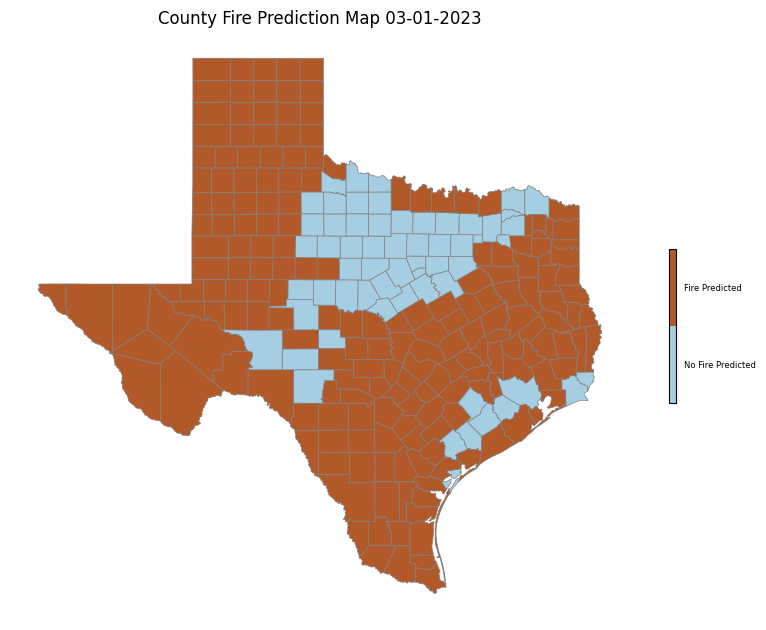

In [21]:
#make statelevel map
make_map(RF, userDate, userState)

<ipython-input-20-9886a906eb6f>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Paired', 2) #PiYG
<ipython-input-20-9886a906eb6f>:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm, shrink = 0.2)


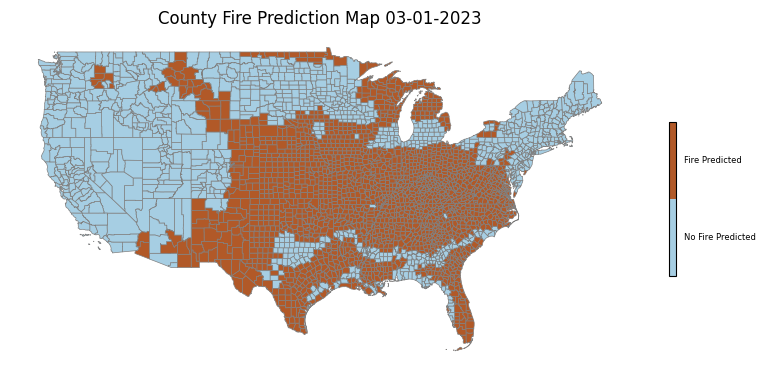

In [22]:
#make county level map
make_map(RF, userDate)